# <center> Temperature Dependence </center>

The objective of this file is to characterize the temperature dependency of the synthesizer. The bandpass filter inside the synthesizer is expected to have the most contribution to this dependency so it will be characterized first.

In [1]:
# Imports
import numpy as np
import pandas as pd
import allantools

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 8.0)

import sys
sys.path.append('../_Modules/')
from labInstrument import csvData

In [2]:
#CSS

from IPython.core.display import HTML
def css_styling():
    styles = open("../Styles/Custom.css", "r").read()
    return HTML(styles)
css_styling()

In [3]:
# Custom Methods

def phase_plot(file_name):
    # file_name: 'testfile.csv'
    # sample_rate: x Hz
    
    data = csvData(file_name).getData()
    time = data[:,0]     # In Seconds
    phase = data[:,2]    # In Degrees
    
    print "Peak to Peak: %.2f°" % (max(phase) - min(phase))
    
    # Plotting the Phase in degrees vs time in hrs
    plt.plot(time/3600, phase+137, label=(file_name[:-4]))
    plt.xlabel('Time (Hrs)')
    plt.ylabel('Phase (Degrees)')
    plt.grid(which='both')
    plt.legend()
    
    return phase

def ADev(file_name, phase, sample_rate): # phase in °
    phase /= 360.*6.4e9 # Converting phase to seconds
        
    # Allan Deviation
    (t2, adev, adev_error, adev_n) = allantools.oadev(phase, rate=sample_rate, taus='all')
    plt.loglog(t2, adev, label=(file_name[:-4]))

    plt.xlabel('Tau')
    plt.ylabel('Allan deviation')
    plt.title('Allan Deviation:')
    plt.grid(which='both')
    plt.legend()

# <center> BPF Results </center>

The phase of the BPF was measured over a long span of time and then plotted below. From the peak to peak variation of the phase, an approximate phase to temperature conversion can be obtained. The allan deviation was also plotted to verify results.

Peak to Peak: 3.39°
Peak to Peak: 59.15°


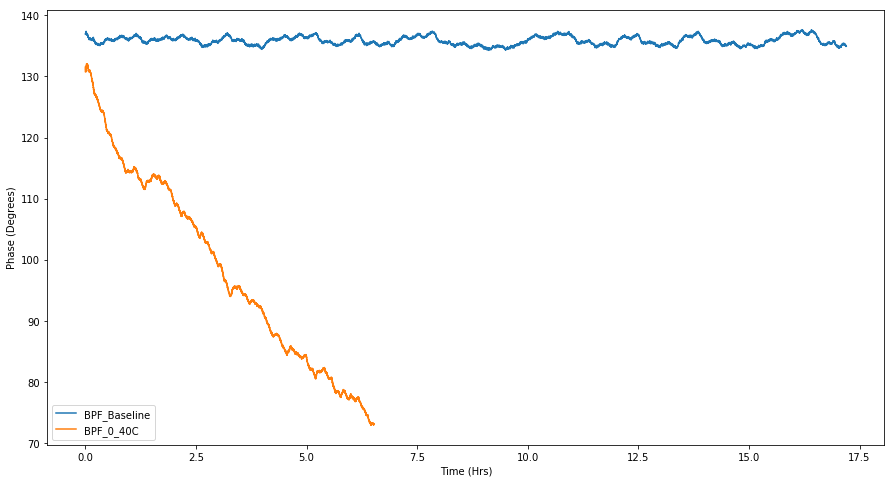

In [4]:
# BPF Results
Baseline = phase_plot('BPF_Baseline.csv') # BPF Baseline
TempVaried = phase_plot('BPF_0_40C.csv')    # Temperature varied BPF

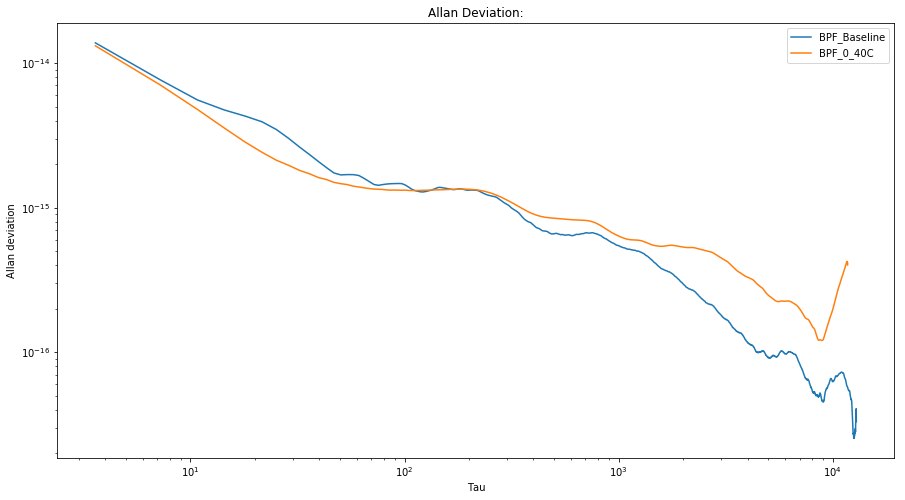

In [5]:
# Corresponding Adev
ADev('BPF_Baseline.csv', Baseline, 0.278)
ADev('BPF_0_40C.csv', TempVaried, 0.278)

For the second test, the BPF was put into a temperature chamber and its temperature varied linearly from 0 to 40°C. From the resulting peak to peak variation in the phase of 59.15°, the conversion from phase to temperature can be approximated by about 1.5° per °C. 

# <center> Approximate Adev Floor of Synth </center>

A simulated allan deviation plot was created using a sin wave with an equivalent amplitude of 4°C peak to peak and a 15 minute cycle time. This is a rough approximation of the effect the A/C might have on the synthesizer box. It should be noted that the synthesizer itself has a thermal resistance due to its mass that will slow the effect of ambient temperature changes.

In [6]:
# Simulating worst case temperature deviation in a room due to A/C

T = 15  # In mins
T *= 60  # Convert to sec
f = 1./T  # Freq in Hz
num_samples = 100000
num_periods = 64
x = np.linspace(0, num_periods*T, num_samples)
A = 3
y = A*np.sin(2*np.pi*f*x)
phase = y/(360*6.4e9)

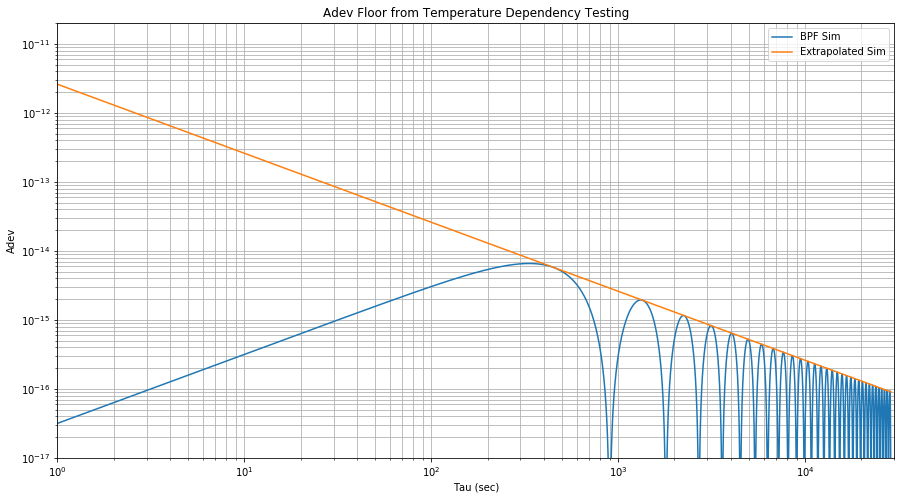

In [7]:
# Adev Floor

sample_rate = f*num_samples/num_periods

(t2, adev, adev_error, adev_n) = allantools.oadev(phase, rate=sample_rate, taus='all')
plt.loglog(t2, adev)
plt.grid(which='both')
plt.xlim(100, 10**5)
plt.title('Adev Floor from Temperature Dependency Testing')
plt.xlabel('Tau (sec)')
plt.ylabel('Adev')
plt.ylim(10**(-17), 2*10**(-11))
plt.xlim(1, 3*10**(4))

y3 = (2*A/(360*6.4e9))/t2
plt.loglog(t2,y3)

plt.legend(['BPF Sim', 'Extrapolated Sim'])
plt.show()

The green line bounds the Adev floor; It represents a 4°C peak to peak change in temperature at a tau interval. Note that the slope of the green line corresponds to the peak to peak variation in temperature and the Tau would represent the interval at which this variation would occur.

# <center> Fractional Freq Error vs Temperature Rate </center>

Given a temperature rate in °C/min, the corresponding fractional freq error is found. This would be used to validate temperature dependency specs of the synthesizer.

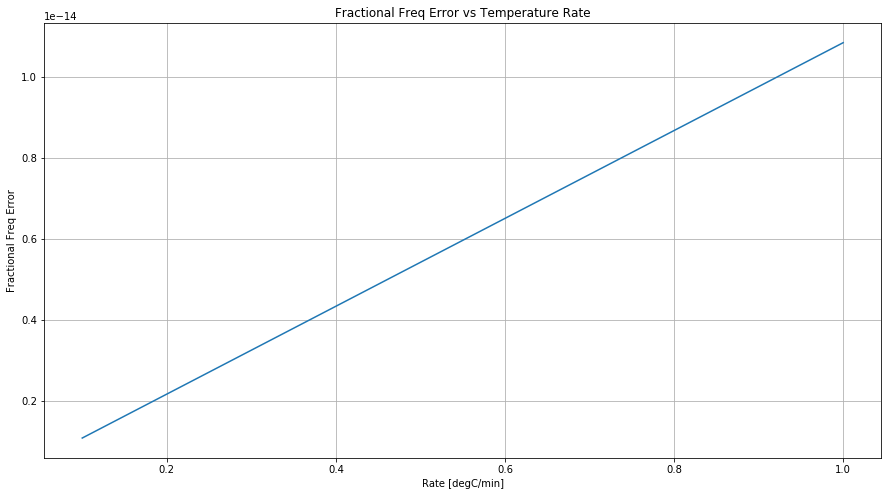

In [8]:
# Fractional Freq Error vs Temperature Rate

delta_c = np.linspace(0.1, 1, 10) # Change in °C per minute

temp_ramp = (delta_c/60)   # Temperature change per sec [°C/sec]
phase_ramp = temp_ramp*1.5 # Phase change per sec [°/sec]
freq_error = phase_ramp/(360*6.4e9) # 

plt.plot(delta_c, freq_error)
plt.xlabel('Rate [degC/min]')
plt.ylabel('Fractional Freq Error')
plt.title('Fractional Freq Error vs Temperature Rate')
plt.grid(which='both')